In [5]:
import atomai as aoi
from atomai.nets import ConvBlock, UpsampleBlock
from atomai.utils import set_train_rng
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
imgdata = np.load("../../graphene_MD_imgs.npy")[::3] # take ~1/3 of the data
print(imgdata.shape)

(2016, 256, 256)


In [3]:
np.random.seed(42) # for reproducibility
# Add noise to data
imgdata_noisy = imgdata + np.random.normal(scale=8, size=imgdata.shape)

Text(0.5, 1.0, 'Original image')

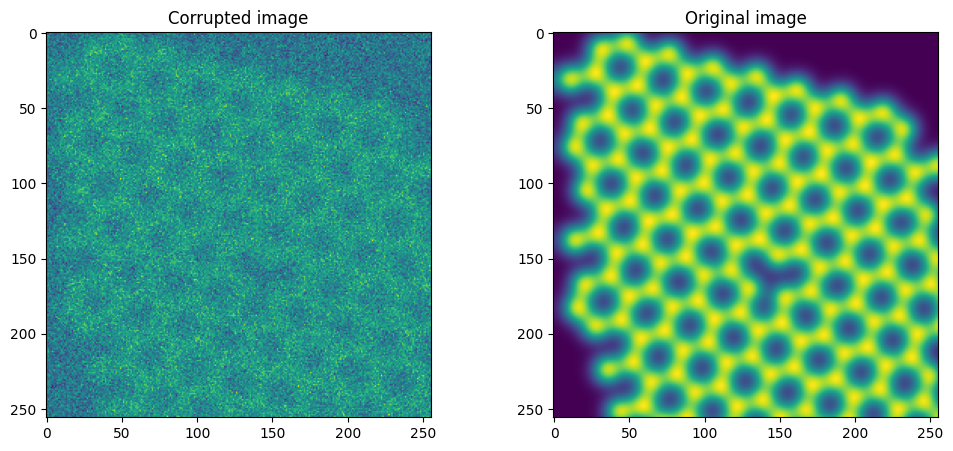

In [6]:
k = 15

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(imgdata_noisy[k])
ax2.imshow(imgdata[k])
ax1.set_title("Corrupted image")
ax2.set_title("Original image")

In [7]:
(imgdata, imgdata_noisy,
 imgdata_test, imgdata_noisy_test)  = aoi.utils.data_split(
     imgdata, imgdata_noisy, format_out="torch_float", channel="first")

In [8]:

torch_encoder = torch.nn.Sequential(
    ConvBlock(ndim=2, nb_layers=1, input_channels=1, output_channels=8, batch_norm=True),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 8, 16, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 16, 32, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 32, 64, batch_norm=False)  # technically, this is a "bottleneck layer"
)

torch_decoder = torch.nn.Sequential(
    UpsampleBlock(ndim=2, input_channels=64, output_channels=64, mode="nearest"), # bilinear mode is better but leads to uncontrolled randomness on CPU
    ConvBlock(2, 2, 64, 32, batch_norm=False),
    UpsampleBlock(2, 32, 32, mode="nearest"),  # we can also use it to reduce numbe of "channels"
    ConvBlock(2, 2, 32, 16, batch_norm=False),
    UpsampleBlock(2, 16, 16, mode="nearest"),
    ConvBlock(2, 1, 16, 8, batch_norm=False),
    torch.nn.Conv2d(8, 1, 1) # vanilla 2D convolutional layer without activation
)

torch_DAE = torch.nn.Sequential(torch_encoder, torch_decoder)

In [9]:
trainer = aoi.trainers.BaseTrainer()
trainer.set_model(torch_DAE)

In [10]:
set_train_rng(1)
trainer._reset_weights()
trainer._reset_training_history()

trainer.compile_trainer(
    (imgdata_noisy, imgdata, imgdata_noisy_test, imgdata_test), # training data
    loss="mse", training_cycles=500, swa=True  # training parameters
)

Epoch 1/500 ... Training loss: 68.7291 ... Test loss: 65.7149 ... GPU memory usage: N/A / N/A
Epoch 100/500 ... Training loss: 1.8713 ... Test loss: 2.1159 ... GPU memory usage: N/A / N/A
Epoch 200/500 ... Training loss: 2.1563 ... Test loss: 1.1432 ... GPU memory usage: N/A / N/A
Epoch 300/500 ... Training loss: 1.183 ... Test loss: 0.919 ... GPU memory usage: N/A / N/A
Epoch 400/500 ... Training loss: 0.7043 ... Test loss: 0.727 ... GPU memory usage: N/A / N/A
Epoch 500/500 ... Training loss: 2.1271 ... Test loss: 1.9768 ... GPU memory usage: N/A / N/A
Model (final state) evaluation loss: 1.9894
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.6365
Plotting training history


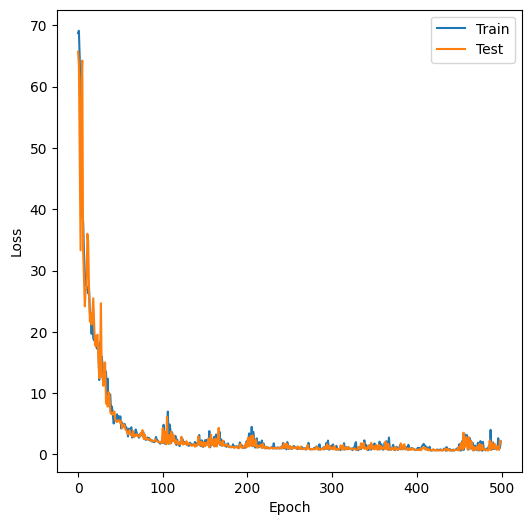

In [11]:
trained_model = trainer.run()

In [12]:
p = aoi.predictors.BasePredictor(trained_model, use_gpu=True)
prediction = p.predict(imgdata_noisy_test)

Text(0.5, 1.0, 'Difference')

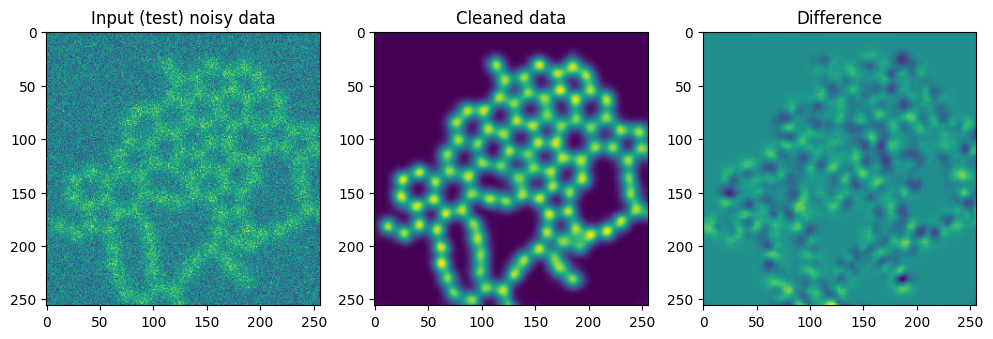

In [13]:

k = 50
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.imshow(imgdata_noisy_test[k,0].cpu())
ax2.imshow(prediction[k,0].cpu())
ax3.imshow(imgdata_test[k,0].cpu() - prediction[k,0].cpu())
ax1.set_title("Input (test) noisy data")
ax2.set_title("Cleaned data")
ax3.set_title("Difference")

In [ ]:
img = imgdata_test[k:k+1]
for s in range(0, 100, 5):
    img = img + np.random.normal(scale=8+s, size=img.shape).astype(np.float32)
    prediction = p.predict(img)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(img[0,0].cpu())
    ax2.imshow(prediction[0,0].cpu())
    ax1.set_title("Input noisy data")
    ax2.set_title("Cleaned data")
    plt.show()

In [14]:
expdata = np.load("../../graphene_exp.npy")
expdata = expdata * 60 # scale it to the range of pixel values used in training data

In [15]:
expdata.shape

(1024, 1024)

In [16]:
expdata.max()

59.992676

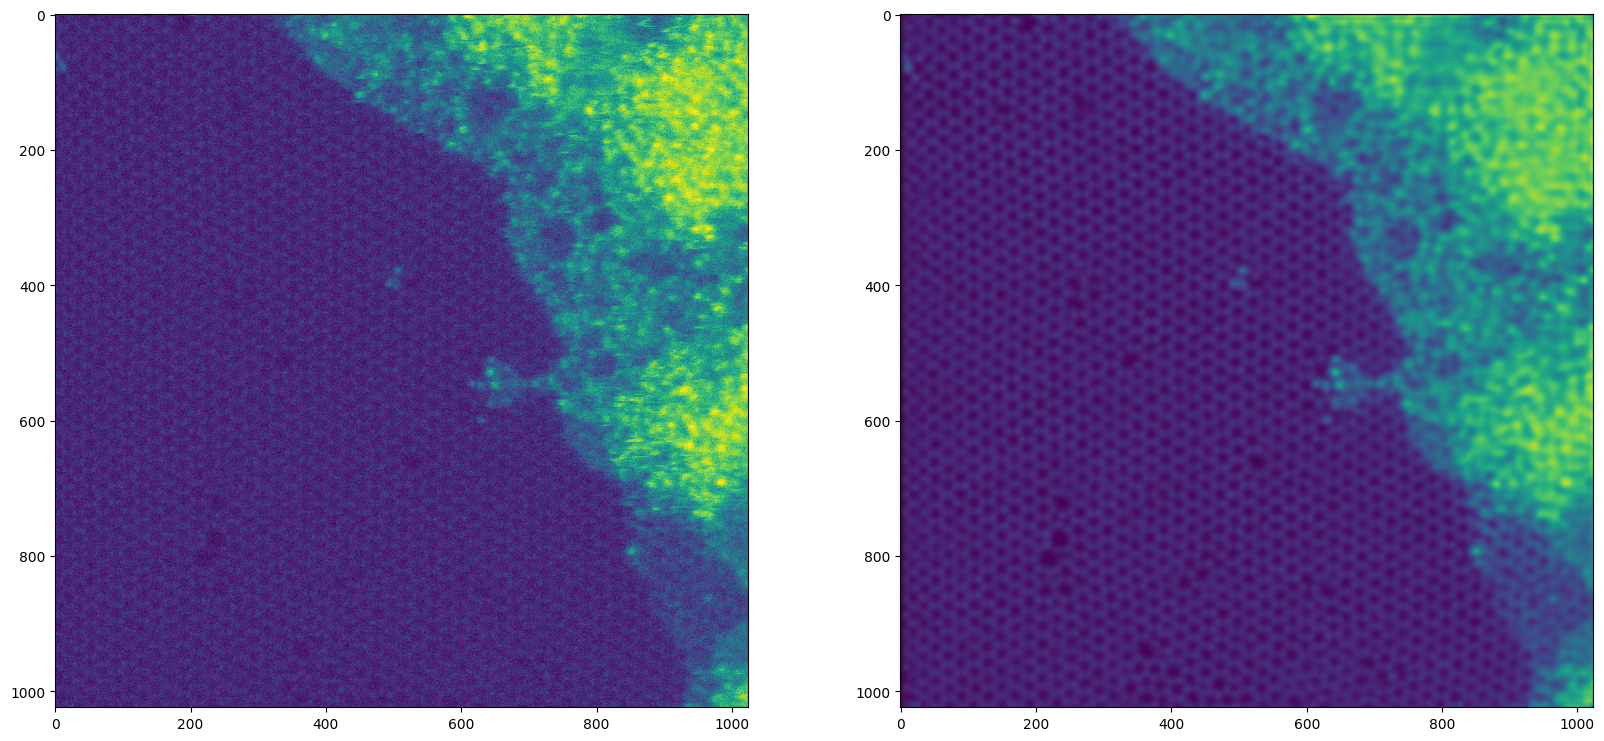

In [17]:
pred = p.predict(expdata[None, None])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(expdata)
ax2.imshow(pred.squeeze())

In [18]:
from os.path import join
import pySPM
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.ndimage import gaussian_filter
from scipy.fft import fftshift, fft2,ifftshift,ifft2,fft,fftfreq
from scipy.signal import hann
from sklearn import preprocessing as pre
from skimage import filters

In [20]:
def my_FFT(img):
    x_p=img.shape[0]
    image_bw=(img-img.min())/(img.max()-img.min())
    image_bw=img
    image_norm=pre.MinMaxScaler().fit_transform(img)
    window_hann = image_bw * hann(x_p, sym=True)
    ft = np.fft.fftshift(np.fft.fft2(window_hann))
    power_spectrum = np.abs(ft) ** 2
    return (power_spectrum-power_spectrum.min())/(power_spectrum.max()-power_spectrum.min())
def display_topo(image,fig,ax,x_n,y_n,title="SiC",scalecolor="white",scalesize=0.3,cmap="Blues_r"):
    #image=gaussian_filter(image,sigma=1)
    Z_image= pySPM.SPM_image(image)
    #Z_image.correct_median_diff()
    #Z_image.correct_lines()
    (y_p,x_p)=image.shape
    Z_image.size["real"]["x"],Z_image.size["real"]["y"]=x_n*1e-9,y_n*1e-9
    Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]=y_p,x_p
    img=Z_image.show(ax=ax,sig=None,cmap=cmap)
    ax.axis ('off')
    Vmin=np.ndarray.min(Z_image.pixels) 
    Vmax=np.ndarray.max(Z_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    scale=int(x_n/10) 
    scalebar=AnchoredSizeBar(ax.transData,scale*2,"{0} nm".format(scale*2),"lower right",pad=1,sep=3,color=scalecolor,label_top=True,frameon=False,size_vertical=scalesize)
    #ax.add_artist(scalebar)
    ax.set_title(title) 
    return img

def read_file(filePath):
    SXMfile=pySPM.SXM(filePath)
    header=SXMfile.header
    Bias=header['BIAS'][0][0]
    Curr=header['Z-CONTROLLER'][1][3]
    Z_image=SXMfile.get_channel('Z')
    #Z_image.correct_median_diff()
    Z_image.correct_lines()
    x_n,y_n=Z_image.size["real"]["x"]*1e9,Z_image.size["real"]["y"]*1e9
    y_p,x_p=Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]
    print("the file is {0},\r\nthe Bias is {1} V,the current is {4} A, the size is {2}*{2} nm,the resolution is {3}*{3} pix ".format(filePath,float(Bias),int(x_n),x_p,Curr))
    return Z_image,x_n

the file is ../../../STMdata/20221206/SiC038.sxm,
the Bias is -0.18 V,the current is 8.000E-11 A, the size is 5*5 nm,the resolution is 512*512 pix 


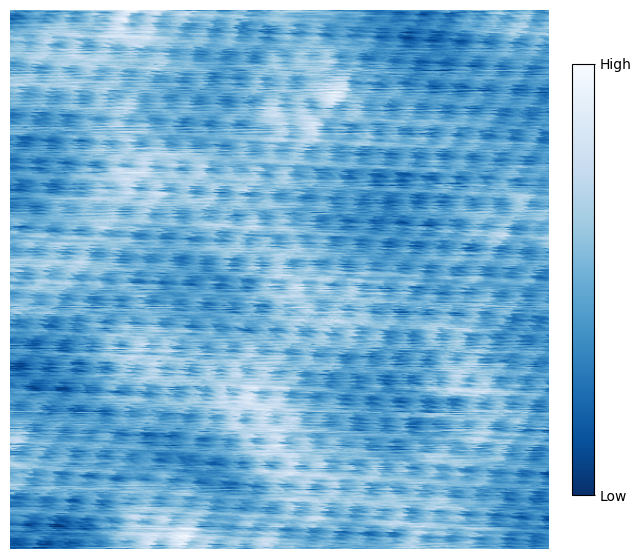

In [21]:
mydir,myFolder,fileName="../../../STMdata","20221206","SiC038.sxm"
filePath=join(mydir,myFolder,fileName)
Z_image,x_n=read_file(filePath)
y_n=x_n
image=Z_image.pixels[::-1,::]
x_p,y_p=image.shape[0],image.shape[1]
zoomFactor=0.12
zoomValue=int(x_p*zoomFactor)
fig,ax = plt.subplots(1,1,figsize=(15,7))
FFT_bw=my_FFT(image)
image=(image-image.min())/(image.max()-image.min())
LargeProfile=display_topo(image,fig,ax,x_n,y_n,title="",scalecolor="white",scalesize=0.15,cmap="Blues_r")

In [22]:
type(image)
expdata=image
expdata = expdata * 60 

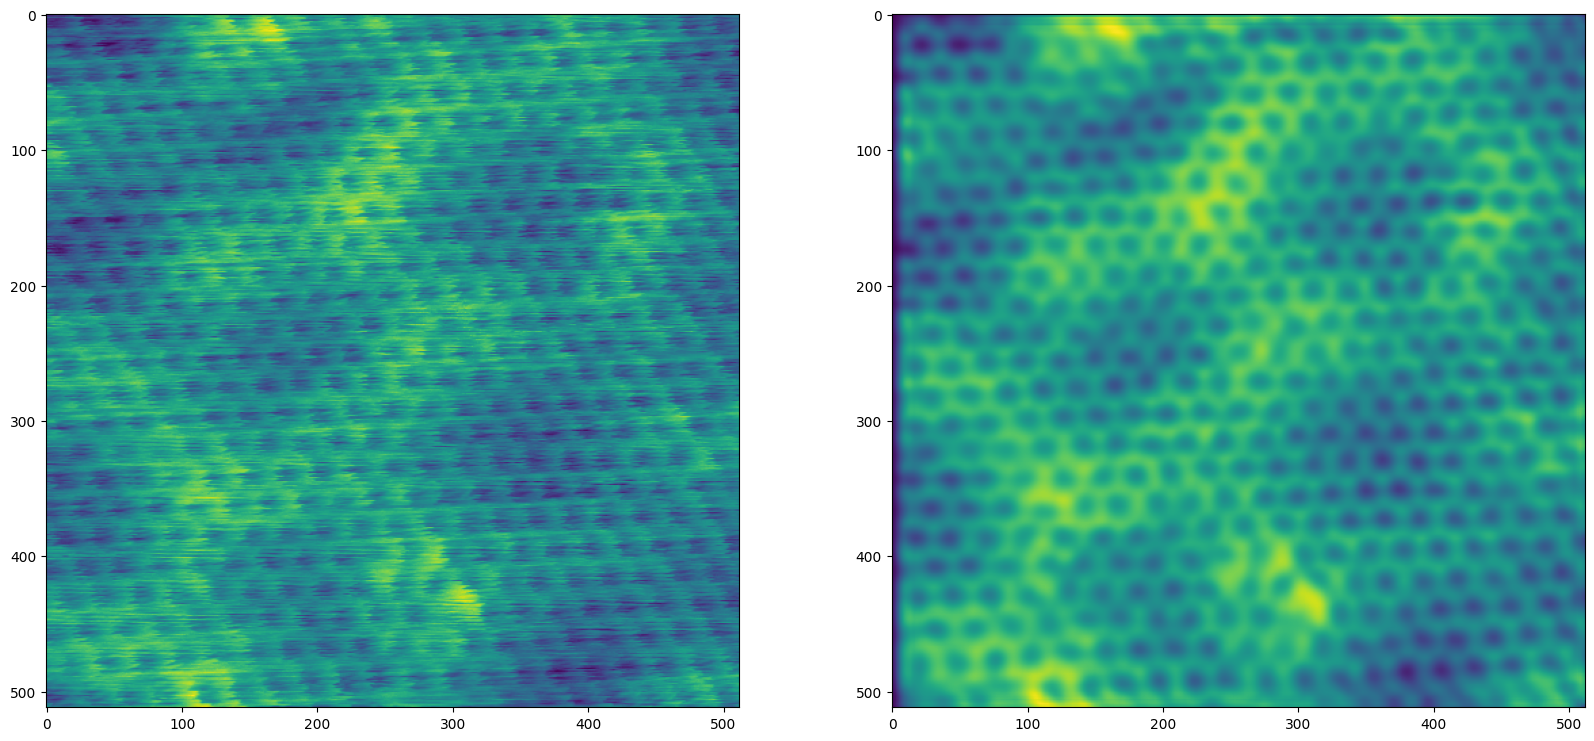

In [23]:
pred = p.predict(expdata[None, None])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(expdata)
ax2.imshow(pred.squeeze())

the file is ../../../STMdata/20221207/SiC011.sxm,
the Bias is -0.2 V,the current is 8.000E-11 A, the size is 20*20 nm,the resolution is 256*256 pix 


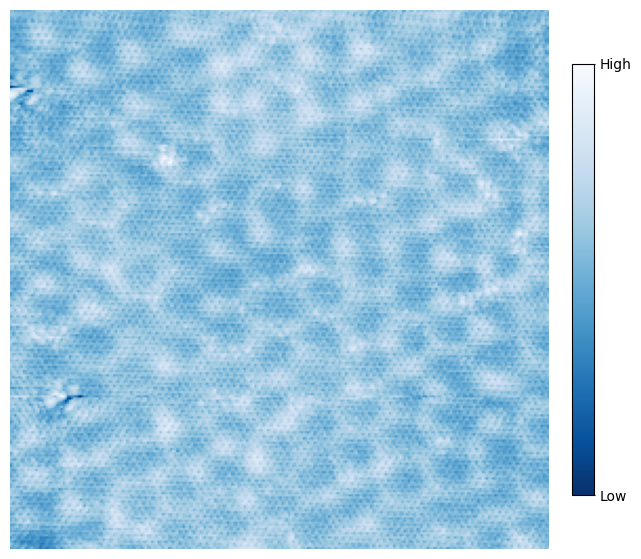

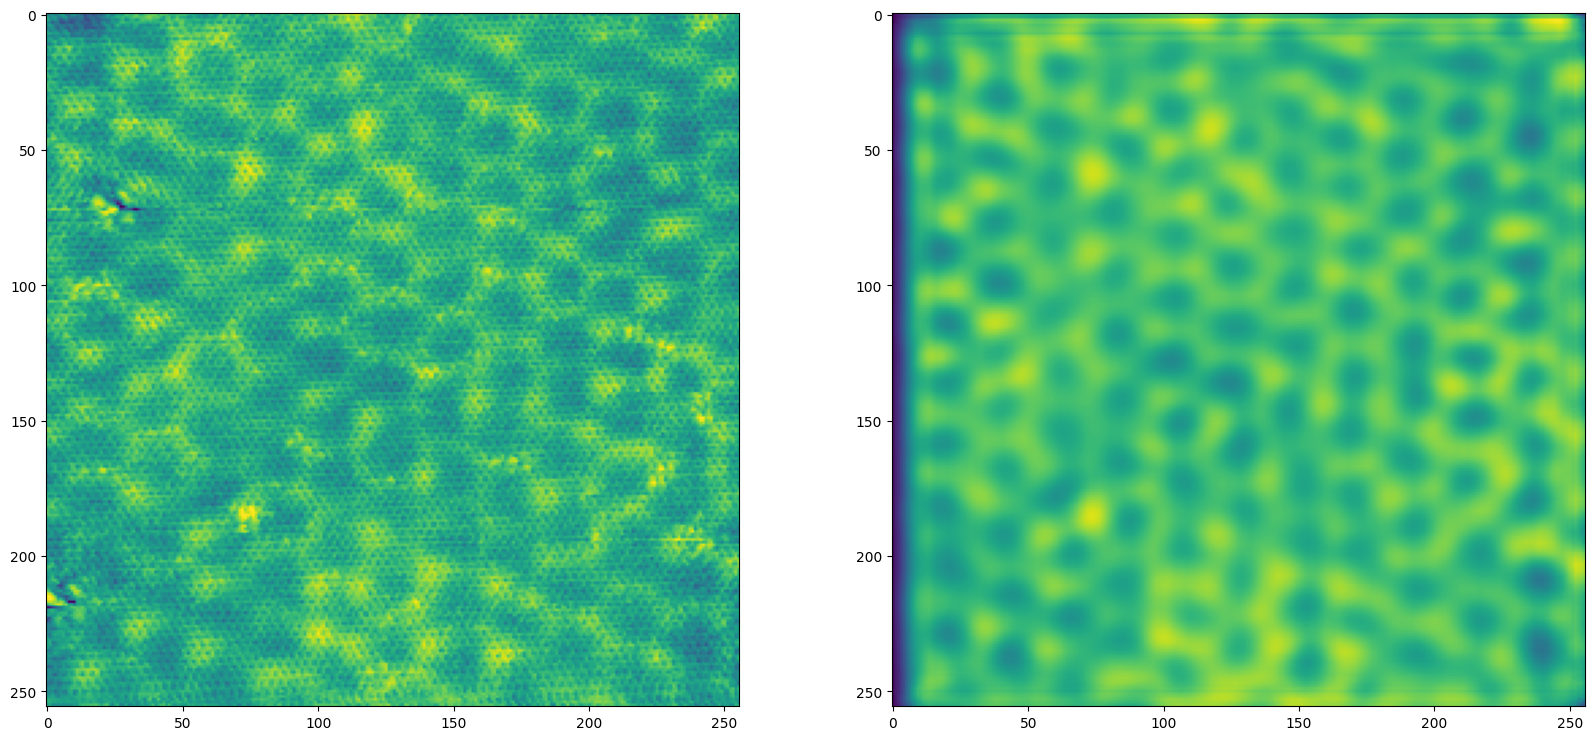

In [24]:
mydir,myFolder,fileName="../../../STMdata","20221207","SiC011.sxm"
filePath=join(mydir,myFolder,fileName)
Z_image,x_n=read_file(filePath)
y_n=x_n
image=Z_image.pixels[::-1,::]
x_p,y_p=image.shape[0],image.shape[1]
zoomFactor=0.12
zoomValue=int(x_p*zoomFactor)
fig,ax = plt.subplots(1,1,figsize=(15,7))
FFT_bw=my_FFT(image)
image=(image-image.min())/(image.max()-image.min())
LargeProfile=display_topo(image,fig,ax,x_n,y_n,title="",scalecolor="white",scalesize=0.15,cmap="Blues_r")


image_sig=copy.deepcopy(image)
image_sig[image_sig>0.9]=0.9
image_sig[image_sig<0.1]=0.1


type(image)
expdata=image_sig
expdata = expdata * 42

pred = p.predict(expdata[None, None])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(expdata)
ax2.imshow(pred.squeeze())